# Lifecycle investing: a statistical approach

This work is reproducing the approach to lifecycle investing using different statistical techniques. In traditional lifecycle investing numerical dynamic programming (NDP) is used to optimize for the consumption of the agent and derive the optimal asset allocation trough time. In our approach we use instead neural networks to derive it.

## Lifecycle Investing

Description of Lifecycle Investing, definition of parameters used, current approach to the solution

The utility function we are optimizing is:

$$V_t(x_t) = \left\{ \left( 1 - \delta \right)C_t^{1-1/\psi} + \delta E_t\left[ p_tV_{t+1}(x_{t+1})^{1-\gamma} \right]^{\frac{1-1/\psi}{1 - \gamma}} \right\}^{\frac{1}{1 - 1/\psi}}$$

When the bequest motive is equal to 0.

The equation is subject to a constrain:

$$x_{t+1} = income_{t+1} + R^p_{t+1}(x_t - C_t)$$

and the return $R^p$ is defined as the return of the portfolio mix between the risky and non risky assets:

$$ R^p_{t+1} = \alpha R_{t+1} + (1 - \alpha)R_f$$

In [4]:
# load libraries
import pandas as pd
import numpy as np
import math
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def epstein_zin_utility(x, wealth, age, risk_asset_return, income):
    total_return = x[1] * risk_asset_return + (1 - x[1]) * risk_free_return
    new_wealth = income + (wealth - x[0]) * np.exp(total_return)
    # I need to add the bequest motive
    expected_future_utility = survival_probability[age] * new_wealth ** (1 - gamma)
    value = ((((1 - delta) * x[0] ** (1 - 1 / psi)) + 
            ((delta * expected_future_utility) ** ((1 - 1 / psi) / (1 - gamma)))) ** 
            (1 / (1 - 1 / psi)))
    return value

def run_lifecycle(iterations = 100):
    for i in range(0, iterations):
        income = [0] * start_age
        risk_asset_return = [0] * start_age
        consumed_wealth = []
        equity_allocation_ts = []
        permanent_income = []
        enne_list = []
        utility_ts = []
        P_t = np.random.normal(scale = income_volatility)
        
        # I use this loop to generate the income and the returns
        for current_age in range(start_age, end_age):
            risk_asset_return.append(np.random.normal(loc = risk_asset_average_return,
                                                    scale = risk_asset_volatility))
            if (current_age < retirement_age):
                income.append(math.exp(initial_income + P_t + np.random.normal(scale = income_volatility)))
            else:
                income.append(0)                                     
            enne_t = np.random.normal(scale = income_volatility)
            permanent_income.append(P_t)
            P_t = P_t + enne_t
            enne_list.append(enne_t)
            # I need to introduce retirement income here too

        consumption = last_consumption
        wealth = consumption
        vtplus1 = ((1 - delta) * wealth ** (1 - 1 / psi)) ** (1 / (1- 1 / psi))
        utility = vtplus1
        utility_ts.append(utility)
        consumed_wealth.append(consumption)
        equity_allocation_ts.append(0)
        fun = lambda x: -epstein_zin_utility(x, wealth, 114, risk_asset_return[114], income[114])
        res = minimize(
            fun,
            [wealth / 2, 0.99],
            method = 'SLSQP',
            bounds=[(0, wealth), (min_equity, 1)],
            )
        consumption = res.x[0]
        equity_allocation = res.x[1]
        utility = np.abs(res.fun)
        utility_ts.append(utility)
        consumed_wealth.append(consumption)
        equity_allocation_ts.append(equity_allocation)
        # I use this loop to reverse-solve the problem
        for current_age in range(end_age - 1, start_age, -1):
            fun = lambda x: -epstein_zin_utility(x, utility, current_age, 
                                                 risk_asset_return[current_age], income[current_age])
            res = minimize(
                fun,
                [utility / 2, 0.99],
                method = 'SLSQP',
                bounds=[(0, utility), (min_equity, 1)],
                )
            #print(current_age)
            #print(utility)
            #print(income[current_age])
            #print(res.x[0])
            consumption = res.x[0]
            equity_allocation = res.x[1]
            utility = np.abs(res.fun)
            utility_ts.append(utility)
            consumed_wealth.append(consumption)
            equity_allocation_ts.append(equity_allocation)

        income_distribution_list.append(income)
        return_distribution_list.append(risk_asset_return)
        utility_ts.reverse()
        utility_ts_list.append(utility_ts)
        consumed_wealth.reverse()
        consumed_wealth_list.append(consumed_wealth)
        equity_allocation_ts.reverse()
        equity_allocation_ts_list.append(equity_allocation_ts)

    print("Training finished.")

In [5]:
# Hyperparameters
start_age = 20
end_age = 115
initial_income = 1
last_consumption = 1
income_volatility = 0.05
risk_asset_average_return = 0.05
risk_asset_volatility = 0.2
risk_free_return = 0.1
delta = 0.96
psi = 0.1
gamma = 10
survival_probability = [0.99] * 115
retirement_age = 70
min_equity = 0.2

# For recording metrics
all_epochs = []
income_distribution_list = []
return_distribution_list = []
consumed_wealth_list = []
equity_allocation_ts_list = []
utility_ts_list = []

C:\Users\andrea\AppData\Local\Temp\ipykernel_3984\3632796276.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  value = ((((1 - delta) * x[0] ** (1 - 1 / psi)) +
C:\Users\andrea\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
C:\Users\andrea\AppData\Local\Temp\ipykernel_3984\3632796276.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  expected_future_utility = survival_probability[age] * new_wealth ** (1 - gamma)


Training finished.


<AxesSubplot:>

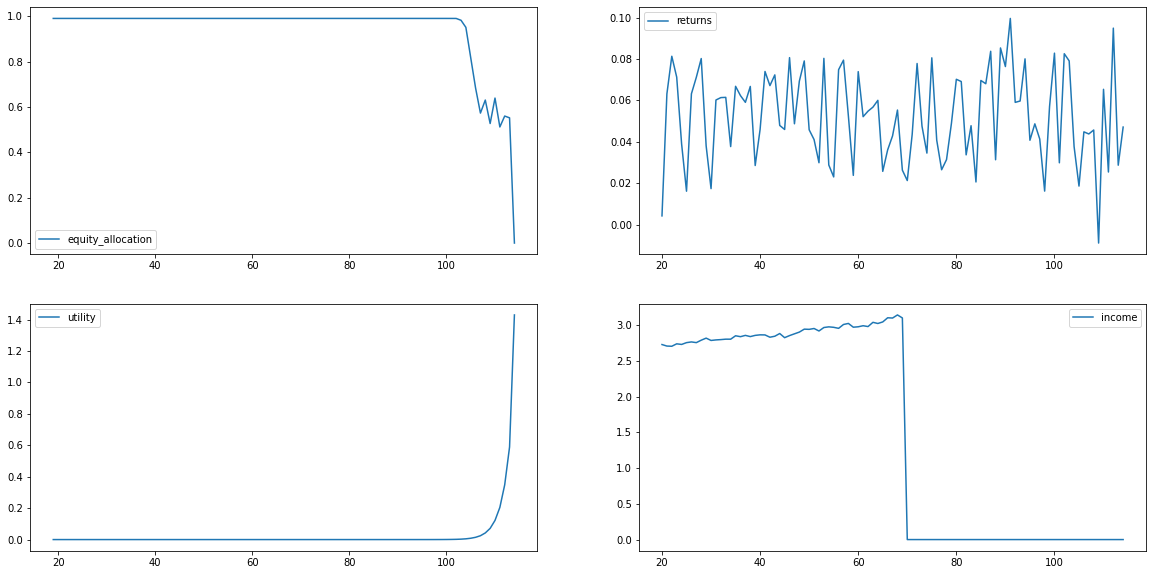

In [6]:
run_lifecycle()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (20, 10))
pd.DataFrame(np.mean(np.array(equity_allocation_ts_list), axis=0), 
    index = range(start_age - 1, end_age),
    columns=["equity_allocation"]).plot(ax = axes[0, 0])
pd.DataFrame(np.mean(np.array(utility_ts_list), axis=0), 
    index = range(start_age - 1, end_age),
    columns=["utility"]).plot(ax = axes[1, 0])
pd.DataFrame(np.mean(np.array(return_distribution_list), axis=0)[start_age:], 
    index = range(start_age, end_age),
    columns=["returns"]).plot(ax = axes[0, 1])
pd.DataFrame(np.mean(np.array(income_distribution_list), axis=0)[start_age:], 
    index = range(start_age, end_age),
    columns=["income"]).plot(ax = axes[1, 1])